# This notebook aims to download recordings and identify sections of audio containing target vocalization, and sections which do not contain the target vocalization. 

__proxy for target vocalisation:__ 
- Audio from a section of a recording contianing target vocalizaition, and taken from within the same timestamp as the tag. 
- Audio from a recording with tagging method 'no restrictions' AND taken from within tag timestamp of the target species. 

__proxys for NOT target vocalization__
- Audio from a recording with tagging method '1SPM' AND there is no target species tag in the recording
- Audio from a recording with tagging method '1SPM' AND there is an target species tag in the recording AND the sample is taken from before the start of the target species tag. 
- Audio from a recording with tagging method 'no restrictions' AND taken from inbetween tags of the target species. 

In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
BASE_PATH = Path.cwd().parents[1]
sys.path.append(str(BASE_PATH / "src" / "data"))  # for clean_csv and train_test_split
sys.path.append(str(BASE_PATH / "src"))  # for utils
from utils import *
%load_ext autoreload
%autoreload 2

In [2]:
df_full = pd.read_pickle(BASE_PATH / "data"/"processed" / "train_set" / "train_set.pkl")

Here's an example of a recording with multiple tags of the same species. In this case, there are 2 olive sided flycatcher tags. 

In [3]:
# display_all(df_full[df_full.media_url == 'https://portal.wildtrax.ca/home/aru-tasks/recording.html?taskId=271849'])

To handle multiple species tags like this, we can keep track of the 'individual_order' field. This is numbered from 1 to n for each individual of the same species tagged in the time period. Alternatively we can just count the number species detections within a time period and infer the individual order. 

In [4]:
df = df_full[keep_cols]
osfls = df.loc[df.species_code == 'OSFL']

### What's the distribution of the different tagging methods?

In [5]:
df.task_method.value_counts(dropna=False)

task_method
1SPT                        201904
1SPM                        178249
NaN                          50291
1SPM Audio/Visual hybrid      2530
Name: count, dtype: int64

#### 1SPT = 1 sample per task <br> 1SPM = 1 sample per minute <br> NaN = no restrictions (assume this is the case for all NaNs) <br> 1SPM treat as 1SPM
- If the tagging method is 1SPT then the time interval is the duration of the recording.
- In each case, the audio before the onset of the target species vocalization can be treated as audio which does not contain the target audio. 
- In the 1SPM recordings, there are additional sources of the negative target, found between the start of each minute, and the onset of the target vocalization within that minute. 
- Initially the two classes will be treated the same, since audio for the null class isn't scarce. 

### What about the 'None' method?
- The 'None' method, or sections of the dataframe without a string value for the tagging method, are tasks without a restriction on the number of tags. These can be used as a source of positive and negative class recordigs. 



## How many recording files are there in the training set?

In [6]:

print(f"{df.recording_id.nunique()} unique recordings, {osfls.recording_id.nunique()} recordings with the target species present.")

54416 unique recordings, 2967 recordings with the target species present.


### Look at how to group df by recording and keep the other info
- recording ids and urls are all the same for each tag entry in the database. 
- It would be useful to have the database indexed by recording ID, and have the species tag, clip start/stop time etc stored as a list per recording. That way we could see the timestamps of all the clips for one recording. 

- Using an aggregate function, we can pass a dictionary into the groupby function so that different columns are grouped differently. This way we can end up with a list of all the target species start stop times per recording. 

#### we want to keep the following columns when working with the recordings:
- recording_url
- task_method
- project
- detection_time
- tag_duration
- latitude
- longitude
- file_type


In [7]:
# column name : aggregation method
recordings_metadata_dict = {
    "recording_url": "first",
    "task_method": "first",
    "project": "first",
    "detection_time": lambda x: list(x),
    "tag_duration": lambda x: list(x),
    "latitude": "first",
    "longitude": "first",
    "file_type": "first",
    "media_url": "first", # for debugging
    "individual_order": "max",
}

In [8]:
target_species = 'OSFL'
target_df = df.loc[df.species_code == target_species]
recordings = target_df.groupby('recording_id').agg(recordings_metadata_dict)
recordings.head()

,recording_url,task_method,project,detection_time,tag_duration,latitude,longitude,file_type,media_url,individual_order
recording_id,,,,,,,,,,
4396,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,1SPM,Boreal Wetland Community Monitoring,"[27.28, 95.9]","[0.83, 1.18]",57.292989,-111.412116,mp3,https://portal.wildtrax.ca/home/aru-tasks/reco...,1.0
4399,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,1SPM,Boreal Wetland Community Monitoring,"[32.63, 82.51]","[1.33, 1.11]",57.467246,-111.215322,mp3,https://portal.wildtrax.ca/home/aru-tasks/reco...,1.0
4427,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,1SPM,Boreal Wetland Community Monitoring,"[106.56, 122.66]","[1.0, 0.84]",57.302163,-111.376885,mp3,https://portal.wildtrax.ca/home/aru-tasks/reco...,1.0
4429,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,1SPM,Boreal Wetland Community Monitoring,"[31.11, 74.7, 139.78]","[1.38, 2.19, 1.29]",57.302163,-111.376885,mp3,https://portal.wildtrax.ca/home/aru-tasks/reco...,1.0
4446,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,1SPM,Boreal Wetland Community Monitoring,"[13.63, 74.88, 126.6]","[1.05, 0.89, 0.8]",57.482905,-111.378761,mp3,https://portal.wildtrax.ca/home/aru-tasks/reco...,1.0


# index by filename for compatibility with opensoundscape

- filenames are formatted <br>
`recording-<recording_id>.<file_type>`

In [9]:
recording_path = BASE_PATH / "data" / "raw" / "recordings" / "OSFL"
recordings['filename'] = recordings.apply(lambda row: 'recording-' + str(row.name) + '.' + row.file_type, axis=1)
# prepend path to the filename column
recordings['path'] = recordings.apply(lambda row: recording_path / row.filename, axis=1)
recordings['relative_path'] = recordings.apply(lambda row: Path('../../data/raw/recordings/OSFL') / row.filename, axis=1)
recordings['filename'].iloc[0]

'recording-4396.mp3'

In [10]:
recordings = recordings.set_index('relative_path')


In [11]:
recordings.head()

,recording_url,task_method,project,detection_time,tag_duration,latitude,longitude,file_type,media_url,individual_order,filename,path
relative_path,,,,,,,,,,,,
../../data/raw/recordings/OSFL/recording-4396.mp3,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,1SPM,Boreal Wetland Community Monitoring,"[27.28, 95.9]","[0.83, 1.18]",57.292989,-111.412116,mp3,https://portal.wildtrax.ca/home/aru-tasks/reco...,1.0,recording-4396.mp3,/Users/mikeg/code/machine_learning/osfl_cnn_re...
../../data/raw/recordings/OSFL/recording-4399.mp3,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,1SPM,Boreal Wetland Community Monitoring,"[32.63, 82.51]","[1.33, 1.11]",57.467246,-111.215322,mp3,https://portal.wildtrax.ca/home/aru-tasks/reco...,1.0,recording-4399.mp3,/Users/mikeg/code/machine_learning/osfl_cnn_re...
../../data/raw/recordings/OSFL/recording-4427.mp3,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,1SPM,Boreal Wetland Community Monitoring,"[106.56, 122.66]","[1.0, 0.84]",57.302163,-111.376885,mp3,https://portal.wildtrax.ca/home/aru-tasks/reco...,1.0,recording-4427.mp3,/Users/mikeg/code/machine_learning/osfl_cnn_re...
../../data/raw/recordings/OSFL/recording-4429.mp3,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,1SPM,Boreal Wetland Community Monitoring,"[31.11, 74.7, 139.78]","[1.38, 2.19, 1.29]",57.302163,-111.376885,mp3,https://portal.wildtrax.ca/home/aru-tasks/reco...,1.0,recording-4429.mp3,/Users/mikeg/code/machine_learning/osfl_cnn_re...
../../data/raw/recordings/OSFL/recording-4446.mp3,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,1SPM,Boreal Wetland Community Monitoring,"[13.63, 74.88, 126.6]","[1.05, 0.89, 0.8]",57.482905,-111.378761,mp3,https://portal.wildtrax.ca/home/aru-tasks/reco...,1.0,recording-4446.mp3,/Users/mikeg/code/machine_learning/osfl_cnn_re...


# First let's build a dataset by downloading only the recordings which contain the target species
### This dataset will also be accompanied by a dataframe with the file path as its index. 

In [12]:
# get a list of the files that have already been downloaded
downloaded_recordings = [file.name for file in (recording_path.glob('*'))]
df_downloaded_recordings = recordings.loc[recordings.filename.isin(downloaded_recordings)]
df_not_downloaded = recordings.loc[~recordings.filename.isin(downloaded_recordings)]
df_not_downloaded.head()

,recording_url,task_method,project,detection_time,tag_duration,latitude,longitude,file_type,media_url,individual_order,filename,path
relative_path,,,,,,,,,,,,
../../data/raw/recordings/OSFL/recording-4396.mp3,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,1SPM,Boreal Wetland Community Monitoring,"[27.28, 95.9]","[0.83, 1.18]",57.292989,-111.412116,mp3,https://portal.wildtrax.ca/home/aru-tasks/reco...,1.0,recording-4396.mp3,/Users/mikeg/code/machine_learning/osfl_cnn_re...
../../data/raw/recordings/OSFL/recording-4399.mp3,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,1SPM,Boreal Wetland Community Monitoring,"[32.63, 82.51]","[1.33, 1.11]",57.467246,-111.215322,mp3,https://portal.wildtrax.ca/home/aru-tasks/reco...,1.0,recording-4399.mp3,/Users/mikeg/code/machine_learning/osfl_cnn_re...
../../data/raw/recordings/OSFL/recording-4427.mp3,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,1SPM,Boreal Wetland Community Monitoring,"[106.56, 122.66]","[1.0, 0.84]",57.302163,-111.376885,mp3,https://portal.wildtrax.ca/home/aru-tasks/reco...,1.0,recording-4427.mp3,/Users/mikeg/code/machine_learning/osfl_cnn_re...
../../data/raw/recordings/OSFL/recording-4429.mp3,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,1SPM,Boreal Wetland Community Monitoring,"[31.11, 74.7, 139.78]","[1.38, 2.19, 1.29]",57.302163,-111.376885,mp3,https://portal.wildtrax.ca/home/aru-tasks/reco...,1.0,recording-4429.mp3,/Users/mikeg/code/machine_learning/osfl_cnn_re...
../../data/raw/recordings/OSFL/recording-4446.mp3,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,1SPM,Boreal Wetland Community Monitoring,"[13.63, 74.88, 126.6]","[1.05, 0.89, 0.8]",57.482905,-111.378761,mp3,https://portal.wildtrax.ca/home/aru-tasks/reco...,1.0,recording-4446.mp3,/Users/mikeg/code/machine_learning/osfl_cnn_re...


In [13]:
# import urllib
# req = urllib.request.Request(df.recording_url.iloc[0], method='HEAD')
# f = urllib.request.urlopen(req)
# f.status
# f.headers['Content-Length']

# TODO: reduce scope of download recordings program. It should just
- Take a list of URLs
- download them and save them to disk
- The rest of the logic (filtering for species code) can be done by another piece of logic separeate from the downloader. 
- Note opensoundscape provides a `download_url` funciton in Audio, and a `save` method for Audio classes

In [14]:
df_not_downloaded

,recording_url,task_method,project,detection_time,tag_duration,latitude,longitude,file_type,media_url,individual_order,filename,path
relative_path,,,,,,,,,,,,
../../data/raw/recordings/OSFL/recording-4396.mp3,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,1SPM,Boreal Wetland Community Monitoring,"[27.28, 95.9]","[0.83, 1.18]",57.292989,-111.412116,mp3,https://portal.wildtrax.ca/home/aru-tasks/reco...,1.0,recording-4396.mp3,/Users/mikeg/code/machine_learning/osfl_cnn_re...
../../data/raw/recordings/OSFL/recording-4399.mp3,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,1SPM,Boreal Wetland Community Monitoring,"[32.63, 82.51]","[1.33, 1.11]",57.467246,-111.215322,mp3,https://portal.wildtrax.ca/home/aru-tasks/reco...,1.0,recording-4399.mp3,/Users/mikeg/code/machine_learning/osfl_cnn_re...
../../data/raw/recordings/OSFL/recording-4427.mp3,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,1SPM,Boreal Wetland Community Monitoring,"[106.56, 122.66]","[1.0, 0.84]",57.302163,-111.376885,mp3,https://portal.wildtrax.ca/home/aru-tasks/reco...,1.0,recording-4427.mp3,/Users/mikeg/code/machine_learning/osfl_cnn_re...
../../data/raw/recordings/OSFL/recording-4429.mp3,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,1SPM,Boreal Wetland Community Monitoring,"[31.11, 74.7, 139.78]","[1.38, 2.19, 1.29]",57.302163,-111.376885,mp3,https://portal.wildtrax.ca/home/aru-tasks/reco...,1.0,recording-4429.mp3,/Users/mikeg/code/machine_learning/osfl_cnn_re...
../../data/raw/recordings/OSFL/recording-4446.mp3,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,1SPM,Boreal Wetland Community Monitoring,"[13.63, 74.88, 126.6]","[1.05, 0.89, 0.8]",57.482905,-111.378761,mp3,https://portal.wildtrax.ca/home/aru-tasks/reco...,1.0,recording-4446.mp3,/Users/mikeg/code/machine_learning/osfl_cnn_re...
...,...,...,...,...,...,...,...,...,...,...,...,...
../../data/raw/recordings/OSFL/recording-826279.flac,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,None,Lebeuf-Taylor - 2023 RETN,[8.31],[1.05],51.678160,-115.306235,flac,https://portal.wildtrax.ca/home/aru-tasks/reco...,1.0,recording-826279.flac,/Users/mikeg/code/machine_learning/osfl_cnn_re...
../../data/raw/recordings/OSFL/recording-826280.flac,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,None,Lebeuf-Taylor - 2023 RETN,[18.88],[0.95],51.678160,-115.306235,flac,https://portal.wildtrax.ca/home/aru-tasks/reco...,1.0,recording-826280.flac,/Users/mikeg/code/machine_learning/osfl_cnn_re...
../../data/raw/recordings/OSFL/recording-826329.flac,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,None,Lebeuf-Taylor - 2023 RETN,[15.06],[0.54],51.714720,-115.335440,flac,https://portal.wildtrax.ca/home/aru-tasks/reco...,1.0,recording-826329.flac,/Users/mikeg/code/machine_learning/osfl_cnn_re...


In [15]:
# number of recordings to download
n = 1

import download_recordings
audio_save_path = Path(BASE_PATH / "data" / "raw" / "recordings" / "OSFL")
audio_save_path.mkdir(parents=True, exist_ok=True)
download_recordings.from_url(df_not_downloaded, 'recording_url', audio_save_path, target = None, n=n)


downloading 1 clips
https://wildtrax-aru-ca.s3.ca-central-1.amazonaws.com/5b698bb8-f078-4e0d-b5d7-dc742b538fb3/553167.flac
skipped 0 previously downloaded files


# use opensoundscape methods to step through recording at intervals

In [16]:
import opensoundscape as oss
from opensoundscape.preprocess.utils import show_tensor_grid

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/ml/cnn.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


#### AudioSplittingDataset makes a set of clips with all the same labels. 
- This isn't ideal for the task of applying multiple classes to segments of one long recording, but we can use the class to generate the splitting times, then add the labels later. 

There's also the option to use

```python
clip = Audio.from_file('longfilename.wav')
```
which will cut a section out of a longer file without loading it into RAM



In [17]:
pre=oss.SpectrogramPreprocessor(sample_duration=3.0)

In [18]:
training_recording = pd.DataFrame(index=['../../data/raw/recordings/OSFL/recording-100034.mp3'])
splitting_dataset = oss.AudioSplittingDataset(training_recording, pre, overlap_fraction = 0.5)
splitting_dataset.bypass_augmentations=False
tensors = [splitting_dataset[i].data for i in range(9)]
# _ = show_tensor_grid(tensors,3)

Change the index of the dataframe of downloaded recordings so that the file path is the index

In [19]:
downloaded_paths_df = pd.DataFrame(df_downloaded_recordings.index).set_index('relative_path')

```python
AudioSplittingDataset 
'''
NOTE: If you've already created a dataframe with clip start and end times, you can use AudioFileDataset. This class is only necessary if you wish to automatically split longer files into clips (providing only the file paths).
'''
```

There are a few approaches to getting audio clips 

1. either automatically split long audio files into shorter clips using AudioSplittingDataset, then assign each clip with a label after the splits are done

2. Generate a bunch of split times and their corresponding labels within the recordings dataframe, then extract as many clips as needed using AudioFileDataet.

The rest of this notebook explores method 1

### What is the difference between opensoundscape's AudioSplittingDataset and its AudioFileDataset?

- AudioSplittingDataset works on one long file and splits it into clips. 

- AudioFileDataset works on files which are already split, or on long files which have a database of start and end times to make clips from. 


In [20]:
splitting_dataset = oss.AudioSplittingDataset(downloaded_paths_df, pre, overlap_fraction = 0.5)
splitting_dataset

<class 'opensoundscape.ml.datasets.AudioSplittingDataset'> object with preprocessor: Preprocessor with pipeline:
load_audio           Action calling <bound method Audio.from_file o...
random_trim_audio    Augmentation Action calling <function trim_aud...
trim_audio           Action calling <function trim_audio at 0x29a42...
to_spec              Action calling <bound method Spectrogram.from_...
bandpass             Action calling <function Spectrogram.bandpass ...
to_tensor                                                       Action
time_mask            Augmentation Action calling <function time_mas...
frequency_mask       Augmentation Action calling <function frequenc...
add_noise            Augmentation Action calling <function tensor_a...
rescale              Action calling <function scale_tensor at 0x29a...
random_affine        Augmentation Action calling <function torch_ra...
dtype: object

In [21]:
afd_test = oss.AudioFileDataset(downloaded_paths_df, pre)
afd_test

<class 'opensoundscape.ml.datasets.AudioFileDataset'> object with preprocessor: Preprocessor with pipeline:
load_audio           Action calling <bound method Audio.from_file o...
random_trim_audio    Augmentation Action calling <function trim_aud...
trim_audio           Action calling <function trim_audio at 0x29a42...
to_spec              Action calling <bound method Spectrogram.from_...
bandpass             Action calling <function Spectrogram.bandpass ...
to_tensor                                                       Action
time_mask            Augmentation Action calling <function time_mas...
frequency_mask       Augmentation Action calling <function frequenc...
add_noise            Augmentation Action calling <function tensor_a...
rescale              Action calling <function scale_tensor at 0x29a...
random_affine        Augmentation Action calling <function torch_ra...
dtype: object

Both the datasets are a child instance of the pytorch __Dataset__ class. They are always initialized with a preprocessor, and when we print the AudioFileDataset object or any of its child instances, the preprocessor is printed as part of the representation of the class.


__Datasets__ can always be indexed into. Let's test this

In [22]:
# Indexing into the splitting dataset
splitting_dataset[3], splitting_dataset[3].data.shape

(AudioSample(source=../../data/raw/recordings/OSFL/recording-4684.mp3, start_time=4.5,end_time=7.5, labels=Series([], Name: (../../data/raw/recordings/OSFL/recording-4684.mp3, 4.5, 7.5), dtype: float64)),
 torch.Size([1, 129, 515]))

In [23]:
# Indexing into the audio file dataset
afd_test[3], afd_test[3].data.shape

(AudioSample(source=../../data/raw/recordings/OSFL/recording-4830.mp3, start_time=96.86051617584636,end_time=99.86051617584636, labels=Series([], Name: ../../data/raw/recordings/OSFL/recording-4830.mp3, dtype: float64)),
 torch.Size([1, 129, 515]))

Neither of the datasets have labels yet. 

In [24]:
# splitting_dataset[3].label, afd_test[3].label
## returns an error. 


Initially our dataset has only long files with timestamps for start and duration of bird calls. 

To get a dataset from these long audio files, we could make a picker which chooses a 3s sample from before the onset of the target species, or one which chooses from within the window of the target species. 

If we use AudioSplittingDataset to automatically create split times, the returned label df is multi-indexed and the labels would all be the same for each file in the long recordings folder. It is difficult to apply custom entries to each entry in a multi-indexed dataframe. 

As a workaround, I've re-indexed the database to accept custom entries, then converted the database back to multi-index. 

This might not be the final method for getting multiple clips from long audio files if I come up with a simpler approach. 




In [25]:
# multi-indexed dataframe
splitting_dataset.label_df.head()

Empty DataFrame
Columns: []
Index: [(../../data/raw/recordings/OSFL/recording-4684.mp3, 0.0, 3.0), (../../data/raw/recordings/OSFL/recording-4684.mp3, 1.5, 4.5), (../../data/raw/recordings/OSFL/recording-4684.mp3, 3.0, 6.0), (../../data/raw/recordings/OSFL/recording-4684.mp3, 4.5, 7.5), (../../data/raw/recordings/OSFL/recording-4684.mp3, 6.0, 9.0)]

In [26]:
# single-indexed dataframe
clip_splits = splitting_dataset.label_df.reset_index()
clip_splits

,file,start_time,end_time
0,../../data/raw/recordings/OSFL/recording-4684.mp3,0.0,3.0
1,../../data/raw/recordings/OSFL/recording-4684.mp3,1.5,4.5
2,../../data/raw/recordings/OSFL/recording-4684.mp3,3.0,6.0
3,../../data/raw/recordings/OSFL/recording-4684.mp3,4.5,7.5
4,../../data/raw/recordings/OSFL/recording-4684.mp3,6.0,9.0
...,...,...,...
60675,../../data/raw/recordings/OSFL/recording-82901...,171.0,174.0
60676,../../data/raw/recordings/OSFL/recording-82901...,172.5,175.5
60677,../../data/raw/recordings/OSFL/recording-82901...,174.0,177.0
60678,../../data/raw/recordings/OSFL/recording-82901...,175.5,178.5


In [27]:
# merge the single indexed dataframe with the original data, so that each clip has the detection times necessary to calculate the label
df = clip_splits.merge(df_downloaded_recordings, left_on='file', right_index=True)
df.head()

,file,start_time,end_time,recording_url,task_method,project,detection_time,tag_duration,latitude,longitude,file_type,media_url,individual_order,filename,path
0,../../data/raw/recordings/OSFL/recording-4684.mp3,0.0,3.0,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,1SPM,Boreal Wetland Community Monitoring,"[8.44, 74.48, 132.45]","[0.81, 0.71, 0.73]",57.417461,-111.246096,mp3,https://portal.wildtrax.ca/home/aru-tasks/reco...,1.0,recording-4684.mp3,/Users/mikeg/code/machine_learning/osfl_cnn_re...
1,../../data/raw/recordings/OSFL/recording-4684.mp3,1.5,4.5,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,1SPM,Boreal Wetland Community Monitoring,"[8.44, 74.48, 132.45]","[0.81, 0.71, 0.73]",57.417461,-111.246096,mp3,https://portal.wildtrax.ca/home/aru-tasks/reco...,1.0,recording-4684.mp3,/Users/mikeg/code/machine_learning/osfl_cnn_re...
2,../../data/raw/recordings/OSFL/recording-4684.mp3,3.0,6.0,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,1SPM,Boreal Wetland Community Monitoring,"[8.44, 74.48, 132.45]","[0.81, 0.71, 0.73]",57.417461,-111.246096,mp3,https://portal.wildtrax.ca/home/aru-tasks/reco...,1.0,recording-4684.mp3,/Users/mikeg/code/machine_learning/osfl_cnn_re...
3,../../data/raw/recordings/OSFL/recording-4684.mp3,4.5,7.5,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,1SPM,Boreal Wetland Community Monitoring,"[8.44, 74.48, 132.45]","[0.81, 0.71, 0.73]",57.417461,-111.246096,mp3,https://portal.wildtrax.ca/home/aru-tasks/reco...,1.0,recording-4684.mp3,/Users/mikeg/code/machine_learning/osfl_cnn_re...
4,../../data/raw/recordings/OSFL/recording-4684.mp3,6.0,9.0,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,1SPM,Boreal Wetland Community Monitoring,"[8.44, 74.48, 132.45]","[0.81, 0.71, 0.73]",57.417461,-111.246096,mp3,https://portal.wildtrax.ca/home/aru-tasks/reco...,1.0,recording-4684.mp3,/Users/mikeg/code/machine_learning/osfl_cnn_re...


### Create a colummn containing a positive label if the tag falls entirely within the clip window. Further development should include partial overlap too. 

In [28]:

df['target_presence'] = df.apply(
    lambda row: np.any(
        (np.array(row['detection_time']) >= row['start_time']) & 
        (np.array(row['detection_time']) + np.array(row['tag_duration']) <= row['end_time'])
    ), 
    axis=1
).astype(int)


### get a sample of 10 recordings with 1SPT task method

In [29]:
df.file

0        ../../data/raw/recordings/OSFL/recording-4684.mp3
1        ../../data/raw/recordings/OSFL/recording-4684.mp3
2        ../../data/raw/recordings/OSFL/recording-4684.mp3
3        ../../data/raw/recordings/OSFL/recording-4684.mp3
4        ../../data/raw/recordings/OSFL/recording-4684.mp3
                               ...                        
60675    ../../data/raw/recordings/OSFL/recording-82901...
60676    ../../data/raw/recordings/OSFL/recording-82901...
60677    ../../data/raw/recordings/OSFL/recording-82901...
60678    ../../data/raw/recordings/OSFL/recording-82901...
60679    ../../data/raw/recordings/OSFL/recording-82901...
Name: file, Length: 60680, dtype: object

In [30]:
spt_recs = df.loc[df.task_method == '1SPT'].sample(10).file
df = df.loc[df.file.isin(spt_recs)]

In [31]:
#Convert detection and tag duration from list to float
# make sure there is only one detection per recording
assert df.detection_time.apply(len).max() == 1
df.tag_duration = df.apply(lambda row: row.tag_duration[0], axis=1)
df.detection_time = df.apply(lambda row: row.detection_time[0], axis=1)
df.tag_duration


AssertionError: 

I expected that 1SPT tag methods would only contain one tag per species per recording, but the tags are done by individual birds - so there can be one or more of the same species in one recording. 

On wildtrax this tag label is called INDIV_ID, and it is in our .csv data as 'individual_order'. When we split the recording into 3s clips, we infer a lot of the metadata for the items in that recording from the original csv file. This works fine at the recording level, but for the time increments we need a method to fill in the species codes and individual order. This isn't implemented yet. 

In [32]:
# links to wildtrax projects where more than one individual per species was detected.
df[df.detection_time.apply(lambda x: len(x) > 1)].media_url.values[:5]

array(['https://portal.wildtrax.ca/home/aru-tasks/recording.html?taskId=271523',
       'https://portal.wildtrax.ca/home/aru-tasks/recording.html?taskId=271523',
       'https://portal.wildtrax.ca/home/aru-tasks/recording.html?taskId=271523',
       'https://portal.wildtrax.ca/home/aru-tasks/recording.html?taskId=271523',
       'https://portal.wildtrax.ca/home/aru-tasks/recording.html?taskId=271523'],
      dtype=object)

In [34]:
df[df.detection_time.apply(lambda x: len(x) > 1)].individual_order.values[:5]

array([3., 3., 3., 3., 3.])

To build the dataset from these data, 
- keep the clips which identify the calls of the all the individual OSFL vocalizations in a task - since these will all be positive examples of the target species.
- Of the remaining clips, drop any clips which occur __after the first__ individual is detected, since these might contain second vocalizations of the first individual which would not be labelled by the listener when using the 1SPT or 1SPM methods. 



##  AudioFileDataset works on a dataframe with a multi index of (path,start_time,end_time) per clip

Check out the docstring for the class:

```python
class AudioFileDataset(torch.utils.data.Dataset):
    """Base class for audio datasets with OpenSoundscape (use in place of torch Dataset)

    Custom Dataset classes should subclass this class or its children.

    Datasets in OpenSoundscape contain a Preprocessor object which is
    responsible for the procedure of generating a sample for a given input.
    The DataLoader handles a dataframe of samples (and potentially labels) and
    uses a Preprocessor to generate samples from them.

    Args:
        samples:
            the files to generate predictions for. Can be:
            - a dataframe with index containing audio paths, OR
            - a dataframe with multi-index of (path,start_time,end_time) per clip, OR
            - a list or np.ndarray of audio file paths

            Notes for input dataframe:
             - df must have audio paths in the index.
             - If label_df has labels, the class names should be the columns, and
            the values of each row should be 0 or 1.
             - If data does not have labels, label_df will have no columns
        preprocessor:
            an object of BasePreprocessor or its children which defines
            the operations to perform on input samples

    Returns:
        sample (AudioSample object)

    Raises:
        PreprocessingError if exception is raised during __getitem__

    Effects:
        self.invalid_samples will contain a set of paths that did not successfully
            produce a list of clips with start/end times, if split_files_into_clips=True
    """
```


To get a dataframe with multi-index of (path, start_time, end_time) per clip we could use the AudioSplittingDataset to generate the clip start and end times, then make a new multi index dataset from these times combined with each recording. 

In [ ]:
# Set multi index for passing into AudioFileDataset
df.set_index(['file', 'start_time', 'end_time'], inplace=True)

In [ ]:
df.sample(5)

,,,recording_url,task_method,project,detection_time,tag_duration,latitude,longitude,file_type,filename,path,target_presence
file,start_time,end_time,,,,,,,,,,,
../../data/raw/recordings/OSFL/recording-312412.mp3,141.0,144.0,https://wildtrax-aru-ca.s3.ca-central-1.amazon...,1SPT,CWS-Ontario Wabakimi 2021,[85.95],[0.78],51.050790,-89.772720,mp3,recording-312412.mp3,/Users/mikeg/code/machine_learning/osfl_cnn_re...,0
../../data/raw/recordings/OSFL/recording-292740.mp3,30.0,33.0,https://wildtrax-aru-ca.s3.ca-central-1.amazon...,1SPT,CWS-Ontario Birds of James Bay Lowlands 2021,[53.4],[0.75],52.997700,-84.438600,mp3,recording-292740.mp3,/Users/mikeg/code/machine_learning/osfl_cnn_re...,0
../../data/raw/recordings/OSFL/recording-255412.mp3,66.0,69.0,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,None,Bayne-OSFL-BU-AnyYr 2021,[30.03],[1.04],57.523776,-111.418890,mp3,recording-255412.mp3,/Users/mikeg/code/machine_learning/osfl_cnn_re...,0
../../data/raw/recordings/OSFL/recording-292665.mp3,165.0,168.0,https://wildtrax-aru-ca.s3.ca-central-1.amazon...,1SPT,CWS-Ontario Birds of James Bay Lowlands 2021,[18.5],[0.96],50.886500,-84.405100,mp3,recording-292665.mp3,/Users/mikeg/code/machine_learning/osfl_cnn_re...,0
../../data/raw/recordings/OSFL/recording-552593.flac,199.5,202.5,https://wildtrax-aru-ca.s3.ca-central-1.amazon...,1SPT,CWS-Ontario Boreal Shield-Lowlands Transition ...,[57.16],[1.36],51.521287,-87.150903,flac,recording-552593.flac,/Users/mikeg/code/machine_learning/osfl_cnn_re...,0


In [ ]:
audio_ds = oss.AudioFileDataset(df, pre)

In [ ]:
tensors = [audio_ds[i].data for i in range(36)]
len(audio_ds)


29892

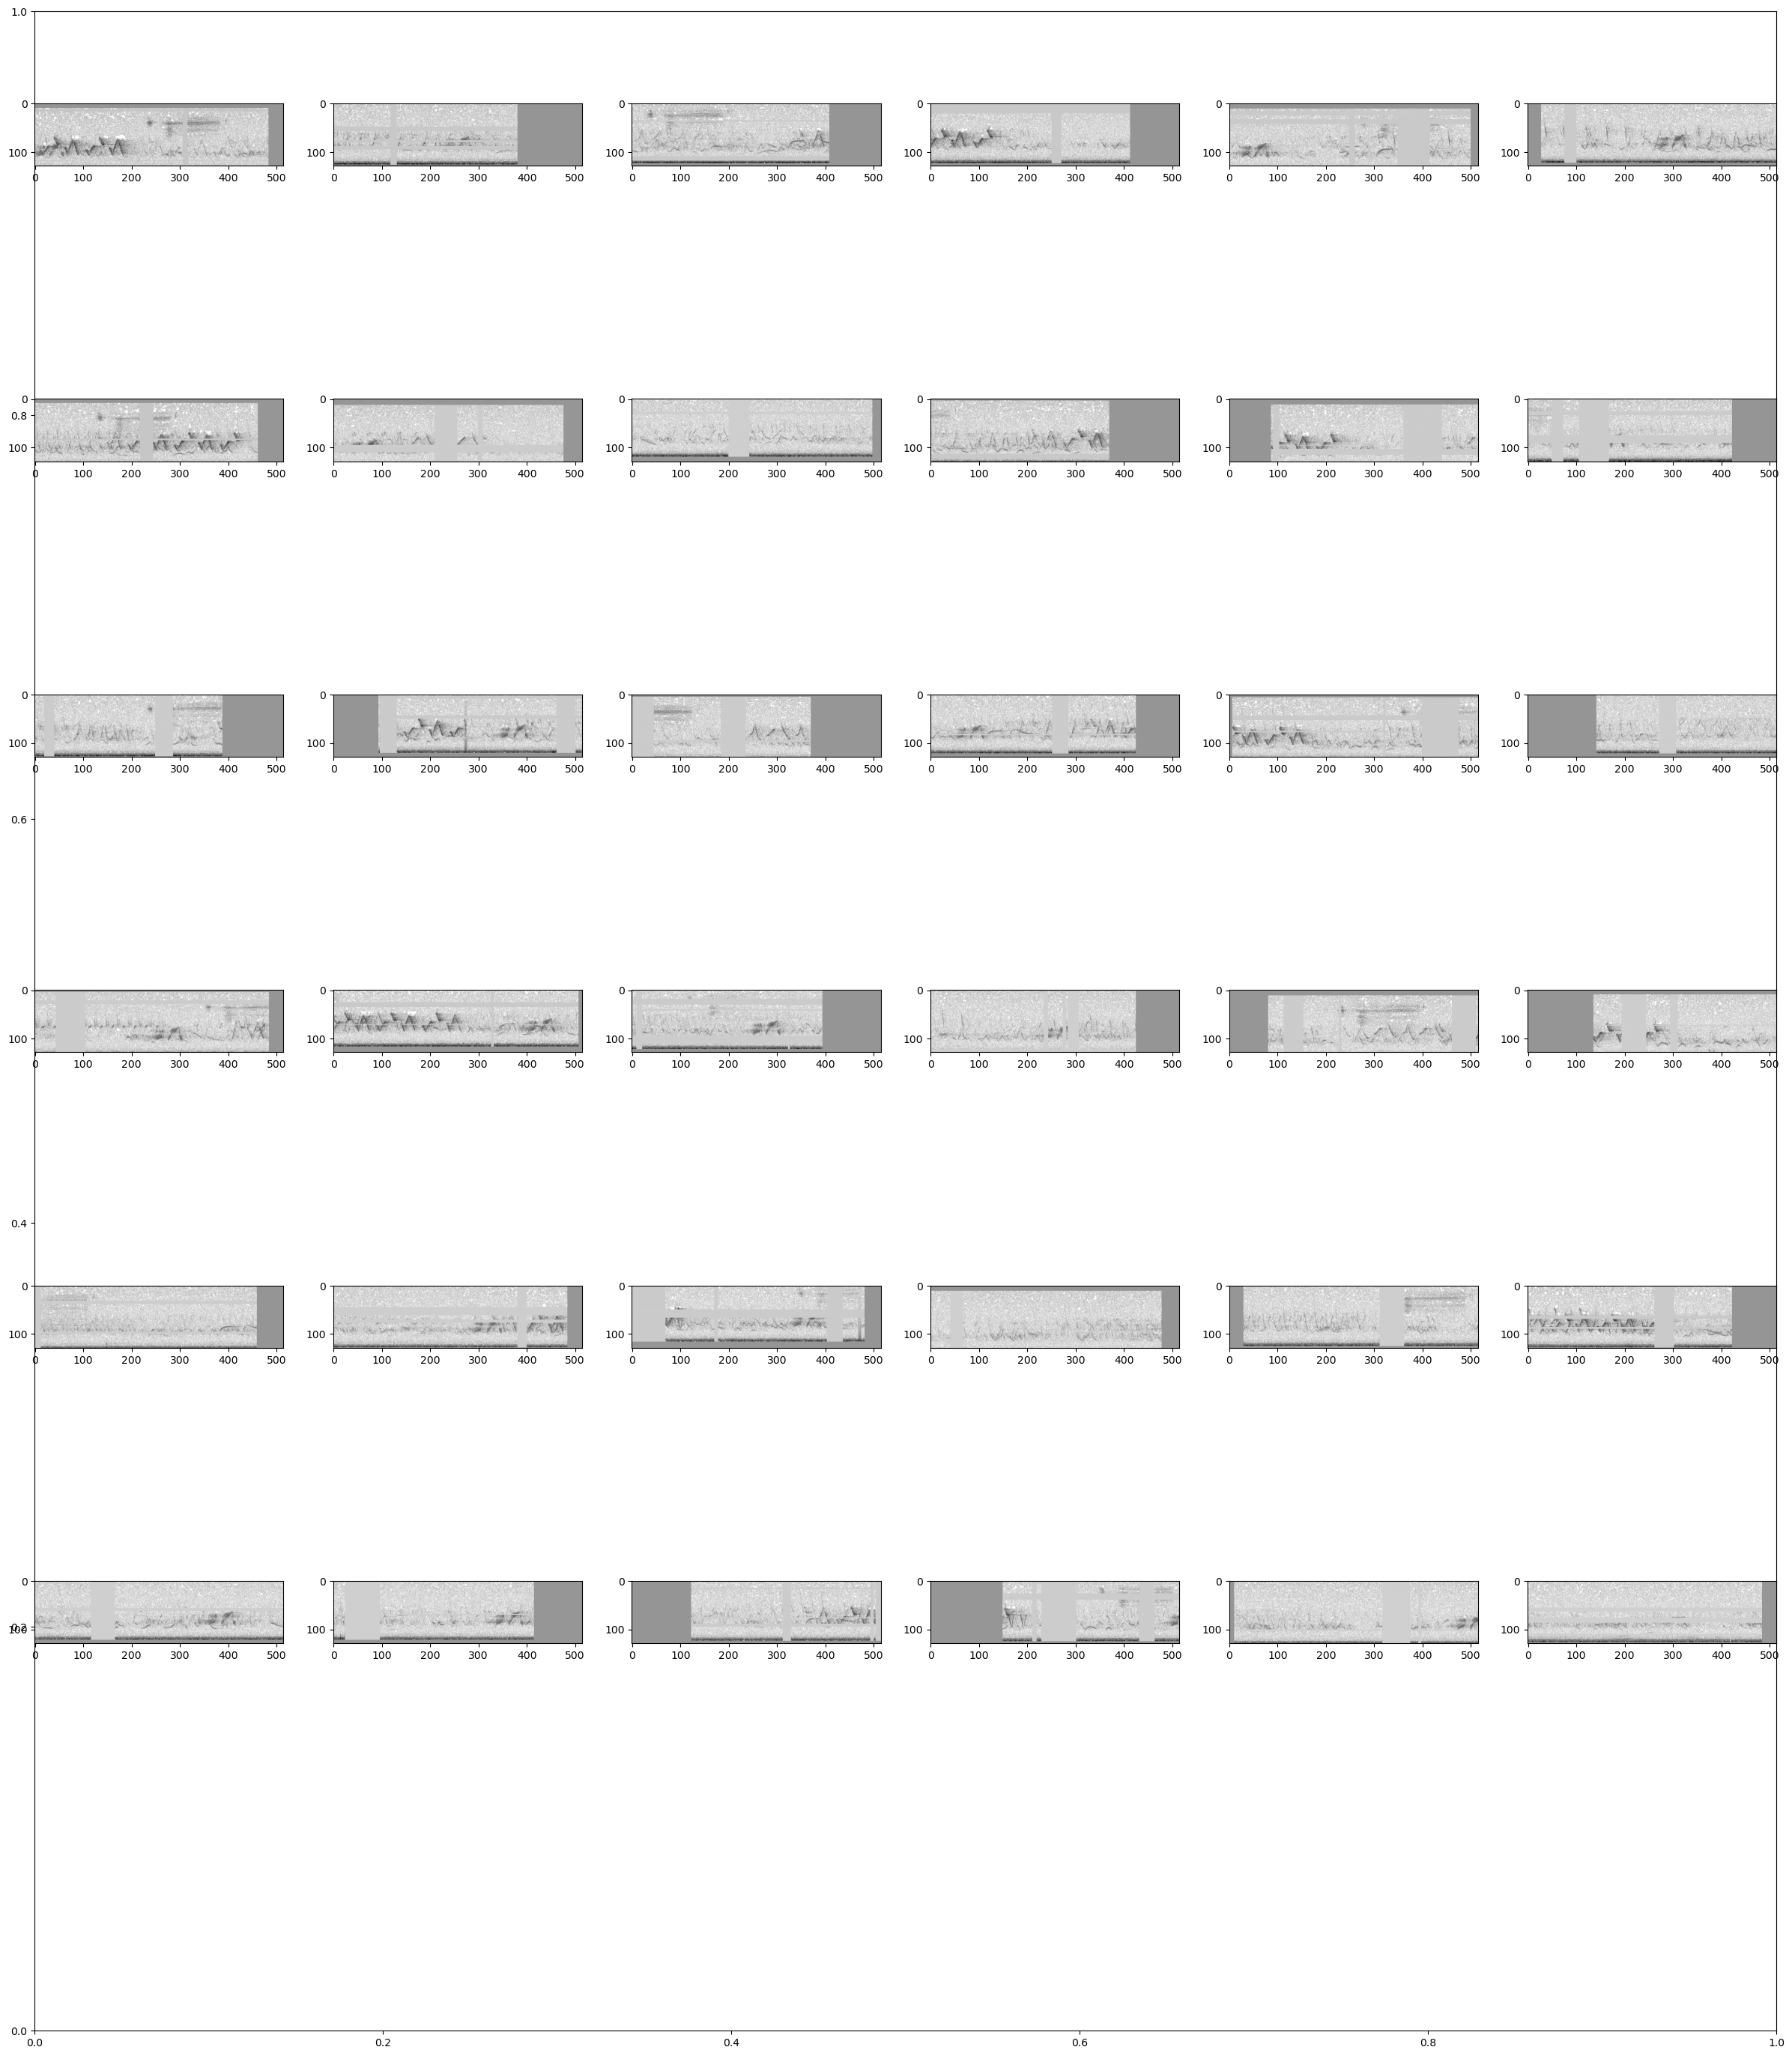

In [ ]:
_ = show_tensor_grid(tensors,6)

# save some files from audio_ds

In [ ]:
oss.AudioFileDataset

opensoundscape.ml.datasets.AudioFileDataset